# LECTURE #3: DIMENSIONALITY REDUCTION
### Outline
+ Goals & Motivation 
+ Principal Components Analysis (PCA)
+ Kernel PCA
+ Fisher's linear discriminant
+ Sparse PCA

### Some resources/references

- <a href=http://research.microsoft.com/pubs/150728/FnT_dimensionReduction.pdf>$\texttt{http://research.microsoft.com/pubs/150728/FnT_dimensionReduction.pdf}$</a> 
A survey of dimensional reduction methods

- _Pattern recognition and machine learning_, Christopher M. Bishop; covers PCA, kernel PCA, probabilistic PCA, and other topics 

- <a href=https://github.com/jakevdp/sklearn_tutorial/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb>$\texttt{https://github.com/jakevdp/sklearn_tutorial/blob/master/notebooks/04.1-Dimensionality-PCA.ipynb}$</a> A sklearn PCA tutorial; some of the code snippets below draw from the tutorial

- <a href=http://colah.github.io/posts/2014-10-Visualizing-MNIST/>$\texttt{http://colah.github.io/posts/2014-10-Visualizing-MNIST/}$</a> A blog post demonstrating how you can visualize MNIST digits; illustrates PCA, among other techniques

- <a href=http://www.di.ens.fr/~fbach/SPO.pdf>$\texttt{http://www.di.ens.fr/~fbach/SPO.pdf}$</a> Some slides on Sparse PCA

# Goals & Motivation

### In a nutshell: 
the mapping of data to a lower dimensional space such that 
most/all of the (useful) information is preserved in the mapping

### What ever for?
- visualization and data exploration
- data compression (save storage space)
- machine learning algorithms often converge more quickly (in terms of time but also in terms of the amount of data needed) as the dimensionality decreases because irrelevant/noisy bits of the data are removed

## let's begin by doing a quick exploration of principal components analysis (PCA)

### basic imports

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set() # you can comment out this line if you don't
# have seaborn installed; it just serves to make some of the plots prettier

/Users/Dexter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### create some normally distributed data and plot

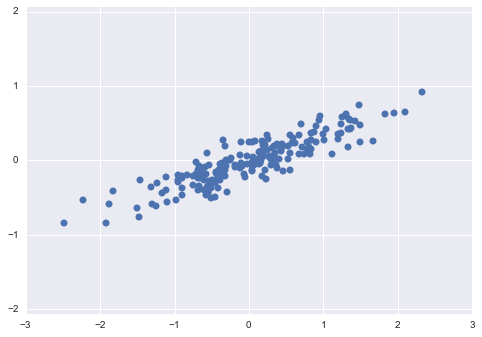

In [2]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal');

### principal components
(in this particular example ~97.6% of the variance is preserved if we project down to the leading principal component)

In [3]:
print("total variance:", np.sum(np.var(X,0)))
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print("variance explained via the first and second components:\n" , pca.explained_variance_)
print("principal components:\n", pca.components_)

total variance: 0.777104349414
variance explained via the first and second components:
 [ 0.75871884  0.01838551]
principal components:
 [[ 0.94446029  0.32862557]
 [ 0.32862557 -0.94446029]]


### let's plot the two principal components

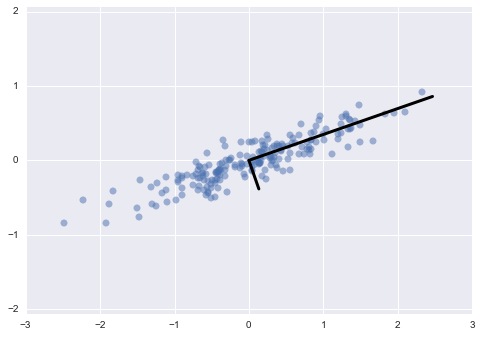

In [4]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

### let's project the data onto the first principal component

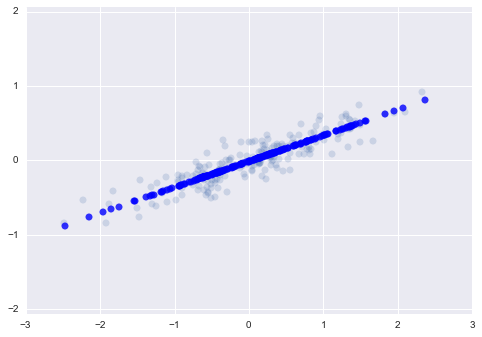

In [5]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)
X_new = clf.inverse_transform(X_trans) # transformed data
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

### this is what would have happened had we instead projected onto the 2nd eigenvector (which only explains a small fraction of the variance)

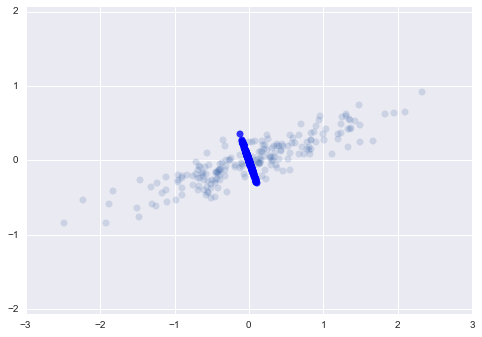

In [6]:
e2=pca.components_[1,:] # this is the 2nd eigenvector
X_new2=(np.dot(X,e2)*e2.reshape((2,1))).T  # this is the data projected onto the 2nd eigenvector
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new2[:, 0], X_new2[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

### so much for the introduction; now on to the math (see Bishop for more details)
<br><br>

# Principal components analysis
## Maximum variance formulation

Consider a dataset $\{\bf{x_n} \}$ with $n=1, ..., N$ and each $\bf{x_n}$ in $\mathbb{R}^D$. We want to project $\{\bf{x_n} \}$ down to a lower-dimensional subspace of $\mathbb{R}^D$ with dimension $d<D$. For now consider $d$ fixed.

Indeed let $d=1$ so that we are considering projecting onto a one-dimensional subspace (a line). This line can be represented by a unit-length vector $\bf{u_1}$. Each point $\bf{x_n}$ gets projected onto a single real number via the inner (dot) product:
$$\begin{equation}
{\bf x_n} \to {\bf x_n}\cdot {\bf u_1}
\end{equation}$$

The mean of the projected data is 
$$\begin{equation}
{\bf \bar{x} \cdot  u_1} = \frac{1}{N} \sum_n {\bf x_n \cdot u_1}
\end{equation}$$

and the variance of the projected data is (switching from dot product notation to transpose and matrix multiplication notation)
$$\begin{equation}
\frac{1}{N} \sum_n \left( \bf u_1^T x_n - u_1^T \bar{x} \right)^2 = {\bf u_1^T S u_1}
\end{equation}$$
where ${\bf S}$ is the data covariance matrix given by

$$\begin{equation}
{\bf S }\equiv \frac{1}{N} \sum_n ( \bf x_n - \bar{x} ) ( \bf x_n - \bar{x} )^T
\end{equation}$$

We want to maximize ${\bf u_1^T S u_1}$ over all unit-length vectors ${\bf u_1}$, i.e. those vectors satisfying:

$$\begin{equation}
{\bf u_1^T u_1 } = 1
\end{equation}$$

To solve this constrained optimization problem we introduce a Lagrange multiplier $\lambda_1$ to enforce the constraint:

$$\begin{equation}
\mathcal{L} = {\bf u_1^T S u_1} + \lambda_1 (1 - {\bf u_1^T u_1 })
\end{equation}$$

Differentiating w.r.t. ${\bf u_1}$ and setting equal to zero we have

$$\begin{equation}
\frac{\partial \mathcal{L}}{\partial {\bf u_1}} =  2{\bf S u_1} -2 \lambda_1 {\bf u_1}=0
\end{equation}$$

that is

$$\begin{equation}
{\bf S u_1} = \lambda_1 {\bf u_1}
\end{equation}$$

which is to say that ${\bf u_1}$ is an eigenvector of ${\bf S}$.

Therefore, in order to maximize the variance of the projection onto ${\bf u_1}$, we should choose ${\bf u_1}$
to be equal to the eigenvector with largest eigenvalue. This eigenvector (which by the way isn't unique) is known as the first principal component.

So we've found the "best" subspace (w.r.t. maximizing the variance that is) for the case $d=1$. What about $d>1$?

Evidently, the "best" subspace for the case $d>1$ is just the subspace spanned by the first $d$ eigenvectors of ${\bf S}$. That is, if we arrange the eigenvalues of ${\bf S}$ in decreasing order with $\lambda_1 \ge \lambda_2 \ge \lambda_3 ...$ and with corresponding eigenvectors ${\bf u_1, u_2, u_3}, ...$ then the best projection is the one that projects onto the subspace formed by $\{ {\bf u_1, u_2, u_3, ..., u_d } \}$


## Minimum error formulation
The above derivation of PCA can actually be arrived at from a different point of view. Instead of searching for the projection which preserves as much of the variance of the data as possible, we search for a projection which minimizes the error induced by the projection. Since these two formulations are ultimately identical, we limit ourselves to a brief discussion---the goal being to provide some additional motivation for and insight into PCA.  To gloss over some slight technical complications, we also assume for convenience that the data are centered ($\bar{\bf{x}} =0$).

Consider a orthonormal basis for $\mathbb{R}^D$ denoted by the vectors $\{ {\bf b_1, b_2, b_3, ..., b_D } \}$. Any vector ${\bf x} \in  \mathbb{R}^D$ has a unique representation as a linear combination of this basis set:

$$\begin{equation}
{\bf x} = \sum_{i=1}^{D} ({\bf x}^T {\bf b_i}){\bf b_i}
\end{equation}$$

If we choose any subset of the basis set, e.g. $\{ {\bf b_1, b_2, b_3, ..., b_d } \}$ with $d<D$ then for most ${\bf x} $ we cannot exactly reconstruct $\bf x$:

$$\begin{equation}
{\bf x} \ne \sum_{i=1}^{d} ({\bf x}^T {\bf b_i}){\bf b_i}
\end{equation}$$

That is, for a given ${\bf x}$ there is a reconstruction error

$$\begin{equation}
E({\bf x}) \equiv  \left|\left|\;{\bf x} - \sum_{i=1}^{d} ({\bf x}^T {\bf b_i}){\bf b_i} \;\right|\right|^2
\end{equation}$$

Without going into the math (e.g. see Bishop for details) it turns out that requiring that the mean reconstruction error over the dataset is as small as possible, i.e. minimizing the quantity

$$\begin{equation}
\frac{1}{N} \sum_{i=1}^{N} E({\bf x_i})
\end{equation}$$

is equivalent to the maximum variance problem we solved above. So choosing the $d$ eigenvectors with largest eigenvalues also ensures that the mean reconstruction error is minimized.

## Applying PCA to digits data

Loaded a total of 1797 digits
the leading principal component:
 [ 0.    0.02  0.22  0.14  0.03  0.1   0.01 -0.    0.    0.12  0.24 -0.15
  0.05  0.22  0.01 -0.    0.    0.08 -0.08 -0.22  0.17  0.16 -0.03 -0.   -0.
 -0.06 -0.25  0.04  0.21  0.04 -0.05 -0.    0.   -0.16 -0.37 -0.16 -0.09
 -0.04 -0.02  0.   -0.   -0.11 -0.3  -0.25 -0.21 -0.01  0.04 -0.   -0.
  0.01  0.06 -0.09 -0.11  0.14  0.06 -0.   -0.    0.01  0.24  0.14  0.01
  0.09  0.04  0.01]


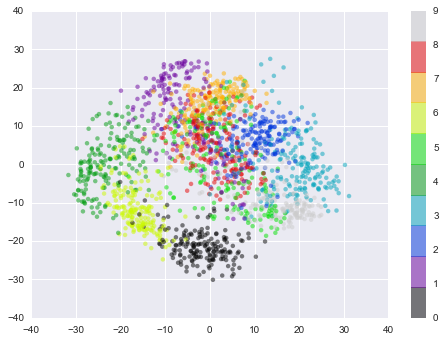

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data # the digits data
y = digits.target # the labels for the digits
print("Loaded a total of", X.shape[0], "digits")

pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();
print("the leading principal component:\n", np.round(pca.components_[0],decimals=2))

## let's look at the eigenvalue spectrum of the digits data
Notice that the first few leading eigenvectors capture a lot of the variance.

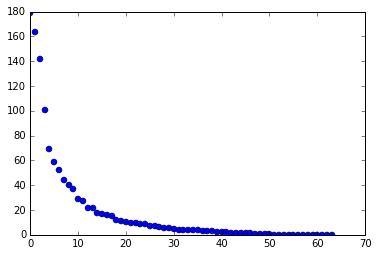

In [8]:
pca = PCA(64)
Xproj = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
plt.plot(np.arange(64), eigenvalues, 'o');

### instead of using the leading two eigenvectors ($u_1$ & $u_2$), let's see the quality of the projection if we use $u_3$ and $u_4$
#### (notice that the separation between the digits is degraded)

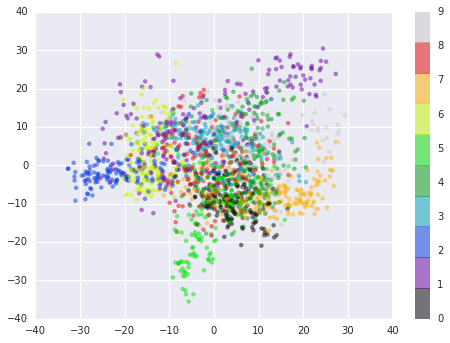

In [27]:
X = digits.data
y = digits.target
pca = PCA(64)  # project from 64 to 4 dimensions
Xproj = pca.fit_transform(X) # we only display dimensions 3 and 4
plt.scatter(Xproj[:, 2], Xproj[:, 3], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

### let's see the quality of the projection if we use $u_{31}$ and $u_{32}$

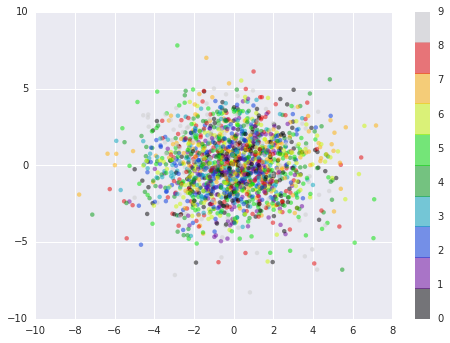

In [28]:
X = digits.data
y = digits.target
pca = PCA(32)  # project from 64 to 4 dimensions
Xproj = pca.fit_transform(X) # we only display dimensions 3 and 4
plt.scatter(Xproj[:, 30], Xproj[:, 31], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

## PCA for compression

<img src="digit_compression.png">

Here we see how well we reconstruct a single zero digit as the number of components (eigenvectors) used in the reconstruction varies from 1 to 64. Figure from the sklearn PCA tutorial linked above.

### let's just look at the 0 and 1 digits (which are well separated in just two dimensions)

Loaded a total of 360 digits (just 0s and 1s)


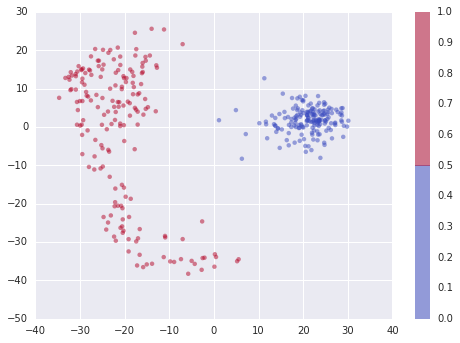

In [29]:
selector = digits.target<2
X = digits.data[selector]
y = digits.target[selector]
print("Loaded a total of", X.shape[0], "digits (just 0s and 1s)")

pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();

### let's look at the 3s and 8s (which are rather poorly separated in just two dimensions)

Loaded a total of 357 digits (just 3s and 8s)


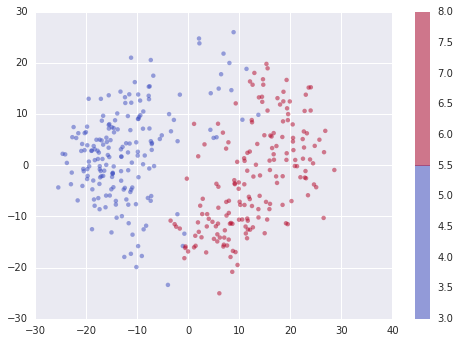

In [30]:
selector = np.logical_or(digits.target==3, digits.target==8)
X = digits.data[selector]
y = digits.target[selector]
print("Loaded a total of", X.shape[0], "digits (just 3s and 8s)")

pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();

# Kernel PCA
One of the disadvantages of PCA is that it only depends on the covariance of the data. Higher moments of the data are not taken into account. A simple nonlinear generalization of PCA called kernel PCA allows us to take higher moments into account. _Let's see if doing kernel PCA let's us get better separation between the 3s and 8s!_

## Kernel methods
In the above we have been working with a given feature space $\mathbb{R}^D$. However, in some cases the given features may not be appropriate for the task at hand. Kernel methods are one way of exploring richer/alternative features for a given dataset. Importantly, because of the so-called kernel trick they can often be quite efficient even if the effective dimensionality of the extended feature set is infinite, since one avoids having to explicitly represent the richer set of features. Since for our present purposes we are really only interested in exploring kernel PCA, a more in-depth introduction to kernel methods will be postponed to a later part of the course.  

The basic idea is that we choose a *fixed* nonlinear feature space mapping $\Phi({\bf x})$ which maps ${\bf x}$ into some (possibly infinite-dimensional) feature space $\mathcal{H}$. We can then proceed to do machine learning (classification, dimensional reduction, etc.) on the features in $\mathcal{H}$. A key stipulation is that we require feature space mappings that result in a non-negative symmetric kernel. That is, we define the kernel function to be given by 

$$\begin{equation}
k({\bf x_1, x_2}) = \Phi({\bf x_1})^T \Phi({\bf x_2})
\end{equation}$$

and require that it is symmetric, $k({\bf x_1, x_2}) = k({\bf x_2, x_1})$, and non-negative, $k({\bf x_1, x_2}) \ge 0$. Note that in this equation the RHS is an inner product in the space $\mathcal{H}$. The whole point of kernel methods is that for certain choices of $\Phi$ and $k$ we can avoid doing this inner product explicitly by making use of the kernel function directly.


## Example kernel to make things more concrete
Probably one of the simplest kernels we can introduce is the polynomial kernel, given by (in the simplest case where the polynomial is degree 2)

$$\begin{equation}
k({\bf x_1, x_2}) = (1 + {\bf x_1^T x_2})^2
\end{equation}$$

Note if $D=2$ so that ${\bf x_i} \in \mathbb{R}^2$ this can equivalently be written as 

$$\begin{equation}
k({\bf x_1, x_2}) = \Phi(x)^T \Phi(x)
\end{equation}$$

where the feature spacing mapping is given by

$$\begin{equation}
\Phi({\bf x}) \equiv [1, \sqrt{2}x_1, \sqrt{2}x_2, x_1^2, x_2^2, \sqrt{2}x_1x_2]
\end{equation}$$

where ${\bf x} = [x_1, x_2]$. In this case $\mathcal{H}$ is 6-dimensional, so we've effectively introduced 4 new features via the non-linearities present in $k({\bf x_1, x_2})$. The beauty of the kernel trick is that we can often avoid explicitly having to calculate $\Phi({\bf x})$ and instead just use the kernel function.


### Let's apply this polynomial kernel to the digits dataset

Loaded a total of 357 digits (just 3s and 8s)


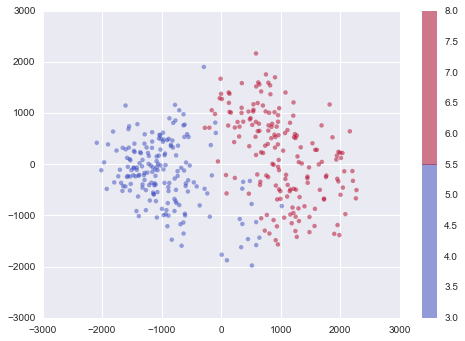

In [16]:
selector = np.logical_or(digits.target==3, digits.target==8)
X = digits.data[selector]
y = digits.target[selector]
print("Loaded a total of", X.shape[0], "digits (just 3s and 8s)")
phi2 = np.transpose(np.einsum('ij,kl', X, X).diagonal(axis1=0, axis2=2).reshape((64*64,357)))
phiX = np.concatenate([X,phi2],axis=1) 
# note that here we are "cheating": we are effectively calculating Phi(x) explicitly, 
# which explains why the code is rather slow. to scale this algorithm up to datasets that
# (i) are much larger; (ii) or for which D or Dim(H) is large
# will require using the kernel trick
                                    
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(phiX)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();

### Unfortunately it's not very clear if introducing non-linearities helped much in separating the 3s and 8s. Let's make an artificial dataset where we can explore the effects of introducing non-linearities a bit more clearly.

In [23]:
X1.size

400

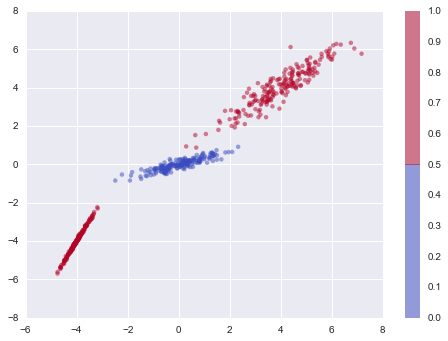

In [17]:
np.random.seed(1)
X1 = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
Y1 = np.ones(200)*0
X2 = [4,4]+np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
Y2 = np.ones(200)*1
X3 = [-4,-4]+np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
Y3 = np.ones(200)*1
X=np.concatenate([X1,X2,X3])  ## create a mixture of three gaussians
Y=np.concatenate([Y1,Y2,Y3])  ## this dataset is evidently not very separable, 
                              ## at least not a simple linear discriminant

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();

#### Let's apply the same polynomial kernel to this artificial dataset
Notice that the red points all have $(x,y) \sim (\pm 4, \pm4)$ with the consequence
that the red points have $(x^2,y^2) \sim (16, 16)$, while the blue points have $(x^2,y^2) \sim (0, 0)$. Thus we expect the non-linear features $x^2$ and $y^2$ to be useful in separating the blue points from the red.

The leading two principal components:
 [[ 0.02412018  0.02067151  0.48866226  0.50029886  0.50029886  0.50951173]
 [-0.70450578 -0.70487688 -0.0409685   0.01720589  0.01720589  0.06745135]]

Notice that the largest coefficients of the leading principal
component are to be found in the last four coordinates
which correspond to the non-linear features


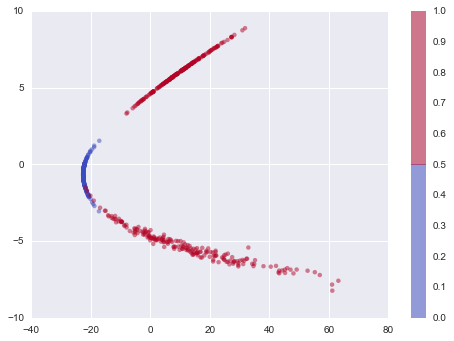

In [18]:
phi2 = np.transpose(np.einsum('ij,kl', X, X).diagonal(axis1=0, axis2=2).reshape((2*2,600)))
phiX = np.concatenate([X,phi2],axis=1)
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(phiX)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();
print("The leading two principal components:\n", pca.components_[0:2])
print("\nNotice that the largest coefficients of the leading principal\ncomponent are to be found in the last four coordinates")
print("which correspond to the non-linear features")

#### Evidently by first projecting to a higher-dimensional space via non-linear mapping _and then_ projecting down to a "good" subspace via PCA, we were able to find a representation of the data that is more suitable to separating the red and blue datapoints.

# Fisher's linear discriminant
###### (This section is based on Bishop section 4.1 so look there for more details)
Up to now, we've been considering data that is unlabeled. What if our data are labeled and we want to make use of the labels in determining how we do dimensionality reduction? 

Consider the case where we have data $\{ {\bf x_i} \}$ with ${\bf x_i}\in \mathbb{R}^D$ where each ${\bf x_i}$ is one of two classes: $\mathcal{C}_1$ (with $N_1$ elements) and $\mathcal{C}_2$ (with $N_2$ elements). We'll be projecting the data onto a single dimension via 

$$\begin{equation}
y = {\bf w^T x}
\end{equation}$$

How to choose the projection vector $\bf w$? One possibility is to maximize the *difference in the class means*. That is, after the projection the class means are given by 

$$\begin{equation}
m_i = {\bf w^T m_i} = \frac{1}{N_i} \sum_{k \in \mathcal{C}_i}  {\bf w^T x_k } \qquad \rm{for} \qquad i=1,2
\end{equation}$$

So we could choose $\bf w$ so as to maximize the quantity $|m_2 - m_1|$ (with the constraint that $\bf w^T w = 1$). If we solve this constrained optimization problem, we find that the solution is given by 

$$\begin{equation}
{\bf w} \propto {\bf m_1 - m_2}
\end{equation}$$

However, this can be a bad choice, as illustrated in the following plot (since the red/blue points will be projected onto the y-axis, there will be significant overlap between red and blue near the origin):

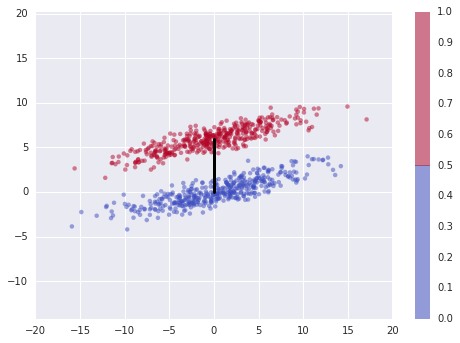

In [35]:
X1 = np.dot(np.array([[5,1],[1,1]]), np.random.normal(size=(2, 400))).T
Y1 = np.ones(400)*0
X2 = [0,6]+np.dot(np.array([[5,1],[1,1]]), np.random.normal(size=(2, 400))).T
Y2 = np.ones(400)*1
X=np.concatenate([X1,X2])  ## concatenate the two gaussian distributions
Y=np.concatenate([Y1,Y2])  

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();
plt.plot([0, 0], [0, 6], '-k', lw=3); # plot the vector (m_1 - m_2)
plt.axis('equal');

So maximizing $|m_2 - m_1|$ doesn't appear to the right approach. The problem with the above projection is that the *within-class variance* can be arbitrarily large. In the above plot, after the projection the within-class variances are rather large (and would be smaller for certain other projections---which we're now going to find).

So one of the foundational figures in statistics (Sir Ronald Aylmer Fisher ) came up with an alternative approach that also takes the within-class variance into account. First, let's define the two within-class variances, $s_1$ and $s_2$:

$$\begin{equation}
s_i^2 = \sum_{k \in \mathcal{C_i}} (y_k - m_k)^2 \qquad \rm{for} \qquad i=1,2
\end{equation}$$

where (as before) $y_k$ is the projection of $\bf x_k$ and $m_k$ is the class mean after the projection. We define the within-class variance for the entire dataset to be given by the sum $s_1^2 +s_2^2$. For a given projection $\bf w$ Fisher then defines a Fisher criterion

$$\begin{equation}
F({\bf w}) = \frac{(m_1 - m_2)^2}{s_1^2 +s_2^2}
\end{equation}$$

which is the ratio of the between-class and within-class variances. The projection is then chosen to maximize this ratio (with the constraint that $\bf w^T w = 1$).


This is a pretty straightforward optimization problem so let's solve it. First we introduce the between-class covariance matrix given by

$$\begin{equation}
{\bf S}_B = ( {\bf m_2 - m_1} ) ( {\bf m_2 - m_1} ) ^T
\end{equation}$$

and the within-class covariance matrix given by

$$\begin{equation}
{\bf S}_W = \sum_{k \in \mathcal{C_1}} ( {\bf x_k - m_1} ) ( {\bf x_k - m_1} ) ^T + \sum_{k \in \mathcal{C_2}} ( {\bf x_k - m_2} ) ( {\bf x_k - m_2} ) ^T
\end{equation}$$

so that we can rewrite the Fisher criterion in matrix notation as

$$\begin{equation}
F({\bf w}) = \frac{{\bf w}^T {\bf S}_B {\bf w} }{{\bf w}^T {\bf S}_W {\bf w}}
\end{equation}$$

Differentiating $F({\bf w})$ w.r.t. ${\bf w}$ and setting equal to zero one finds that

$$\begin{equation}
({\bf w}^T {\bf S}_B {\bf w}) {\bf S}_W {\bf w} = ({\bf w}^T {\bf S}_W {\bf w}) {\bf S}_B {\bf w}
\end{equation}$$

Since ${\bf S}_B$ is just a projector onto the direction ${\bf m_2 - m_1}$ the vector ${\bf S}_B {\bf w}$ always points in the direction ${\bf m_2 - m_1}$. On the other hand, $({\bf w}^T {\bf S}_B {\bf w})$ and $({\bf w}^T {\bf S}_W {\bf w})$ are just numbers. Since we only care about the direction of $\bf w$ and not its magnitude (we are going to normalize it anyway) we just need to multiply both sides of the equation by the inverse of ${\bf S}_W$ to obtain the solution:

$$\begin{equation}
{\bf w}_{\rm{Fisher}} \propto {\bf S}_W^{-1} ( {\bf m_2 - m_1} ) 
\end{equation}$$

So in the general case where ${\bf S}_W$ isn't isotropic (and thus isn't proportional to the identity matrix) ${\bf w}_{\rm{Fisher}}$ will *not* be parallel to ${\bf m_2 - m_1}$. This results in a projector with a smaller between-class variance $|m_1 - m_2|$ but a (potentially) much smaller within-class variance ${s_1^2 +s_2^2}$ (which we saw can be problematic if allowed to be large).

### Let's demonstrate this by calculating ${\bf S}_W$ and ${\bf w}_{\rm{Fisher}}$ for the above case 
(Notice that now we get a linear discriminant that results in good separation between the two classes.)


S_w inverse:
 [[ 0.125 -0.375]
 [-0.375  1.625]]
w_fisher:
 [[-2.25]
 [ 9.75]]


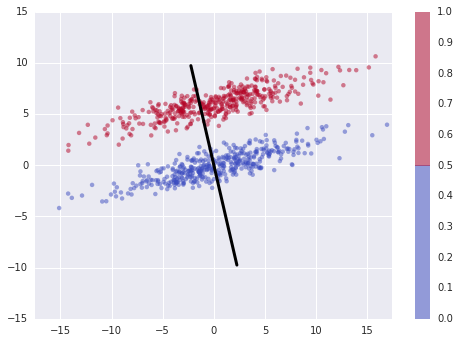

In [36]:
# since the classes are balanced (each has 400 elements) we have
Sw = np.matrix([[5,1],[1,1]])*np.matrix([[5,1],[1,1]])
Sw_inv = np.linalg.inv(Sw)
print("S_w inverse:\n", Sw_inv)
w_fisher = Sw_inv * np.matrix([[0],[6]])  ## calculate the fisher discriminant
print("w_fisher:\n", w_fisher)

X1 = np.dot(np.array([[5,1],[1,1]]), np.random.normal(size=(2, 400))).T
Y1 = np.ones(400)*0
X2 = [0,6]+np.dot(np.array([[5,1],[1,1]]), np.random.normal(size=(2, 400))).T
Y2 = np.ones(400)*1
X=np.concatenate([X1,X2])  ## concatenate the two normally-distributed datasets
Y=np.concatenate([Y1,Y2])  

plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 2))
plt.colorbar();
plt.axis('equal');
plt.plot([w_fisher[0,0],-w_fisher[0,0]], [w_fisher[1,0],-w_fisher[1,0]],
         '-k', lw=3); # plot the fisher discriminant

# Sparse PCA

Standard PCA is relatively quick and easy to implement since it just amounts to finding eigenvectors. One possible drawback of PCA is that the leading eigenvectors will in general have entirely (or almost entirely) non-zero components. We saw this in the case of the digits data. That is, a typical eigenvector is a linear combination of every dimension in the data. This can possibly be an impediment to visualization and data exploration, i.e. it can make interpretability trickier. Also, if your goal is to throw out certain dimensions in the data entirely (say, you stop collecting them in your survey) you don't really want such __dense__ eigenvectors, rather what you want is __sparse__ eigenvectors.

Recall that PCA was formulated as a variance maximization problem. Specifically, we introduced the covariance matrix

$$\begin{equation}
{\bf S }\equiv \frac{1}{N} \sum_n ( \bf x_n - \bar{x} ) ( \bf x_n - \bar{x} )^T
\end{equation}$$

and then aimed to maximize ${\bf u_1^T S u_1}$ over all unit-length vectors ${\bf u_1}$, i.e. those vectors satisfying:

$$\begin{equation}
{\bf u_1^T u_1 } = 1
\end{equation}$$

This will in general lead to a dense ${\bf u_1}$. To get a sparse ${\bf u_1}$ (i.e. one with few non-zero components) we just have to put in an additional constraint.

For example (there are many other possibilities), we maximize ${\bf u_1^T S u_1}$ subject to the constraint that $\rm{Card}({\bf u_1})=k$ where $\rm{Card}({\bf u_1})$ is the number of non-zero constraints in $\bf u_1$. Of course, writing down this equation doesn't mean we know how to solve it. And in general solving this sort of constrained optimization problem is going to be much trickier than regular PCA, which is substantially easier to solve. Consequently, we won't get into the details here. Instead let's show a visualization that highlights the results of using this kind of sparse PCA procedure. In the homework you'll be asked to play around with Sparse PCA on some real data.



<img src="faces_pca.png">
<img src="faces_spca.png">

These two images show the basis vectors found by PCA (top) and Sparse PCA (bottom) for a dataset of face images (taken from the sklearn documentation). Note that the Sparase PCA eigenfaces are very sparse (mostly gray).